Import Libraries

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Load Dataset

In [22]:
df = pd.read_csv('results.csv')
print("First 5 rows:")
print(df.head())
print("\nDataset info:")
print(df.info())

First 5 rows:
                        _id isPb    wpm     acc  rawWpm  consistency  \
0  691b6ac6d8e248a53b1ae97b  NaN  79.99   96.63   79.99        65.69   
1  69169bbf73393afa8b6d0ed0  NaN  70.80   94.87   74.00        65.44   
2  6912c9773ba5c3033763358a  NaN  92.61   94.83  124.91        92.98   
3  6912c9483ba5c303376333b6  NaN  99.95  100.00   99.95        73.30   
4  6912c92c3ba5c30337633290  NaN  79.28   92.86  113.84        82.97   

   charStats   mode  mode2  quoteLength  ...  punctuation  numbers  language  \
0  200;0;0;0   time     30           -1  ...        False    False   english   
1  177;1;0;1   time     30           -1  ...        False    False   english   
2   43;0;1;1  words     10           -1  ...        False    False   english   
3   46;0;0;0  words     10           -1  ...        False    False   english   
4   39;1;1;1  words     10           -1  ...        False    False   english   

   funbox  difficulty  lazyMode blindMode  bailedOut tags      timestamp

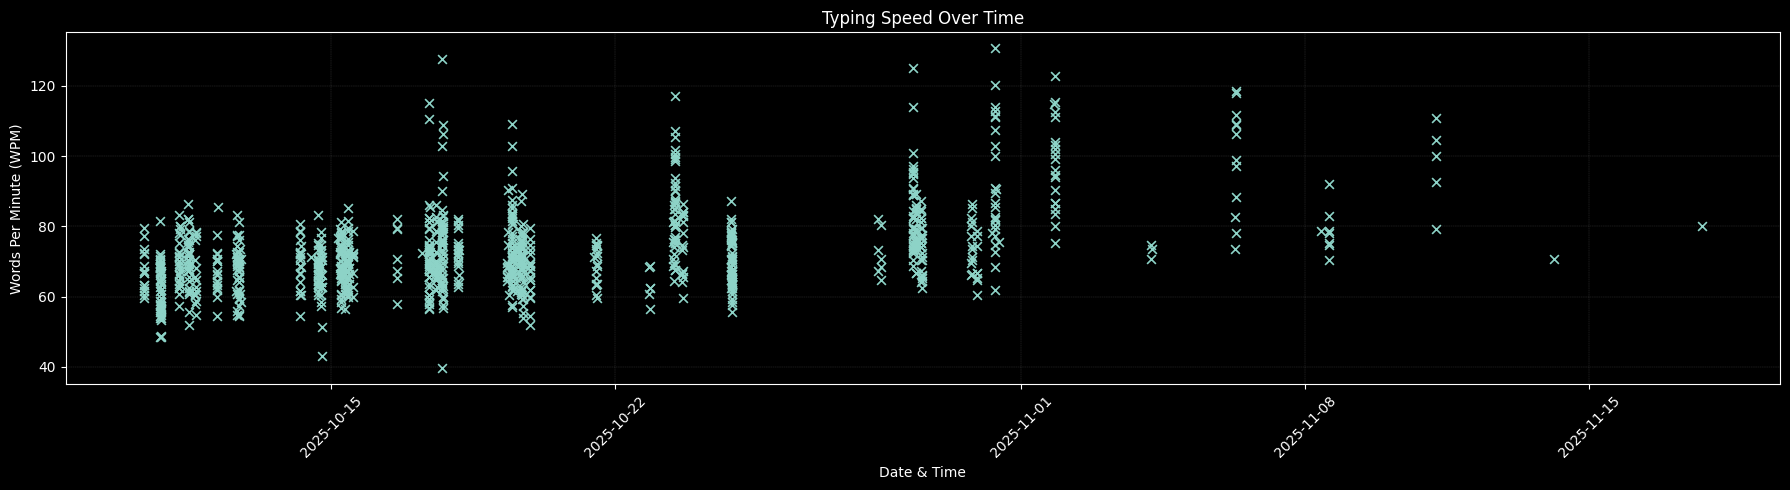

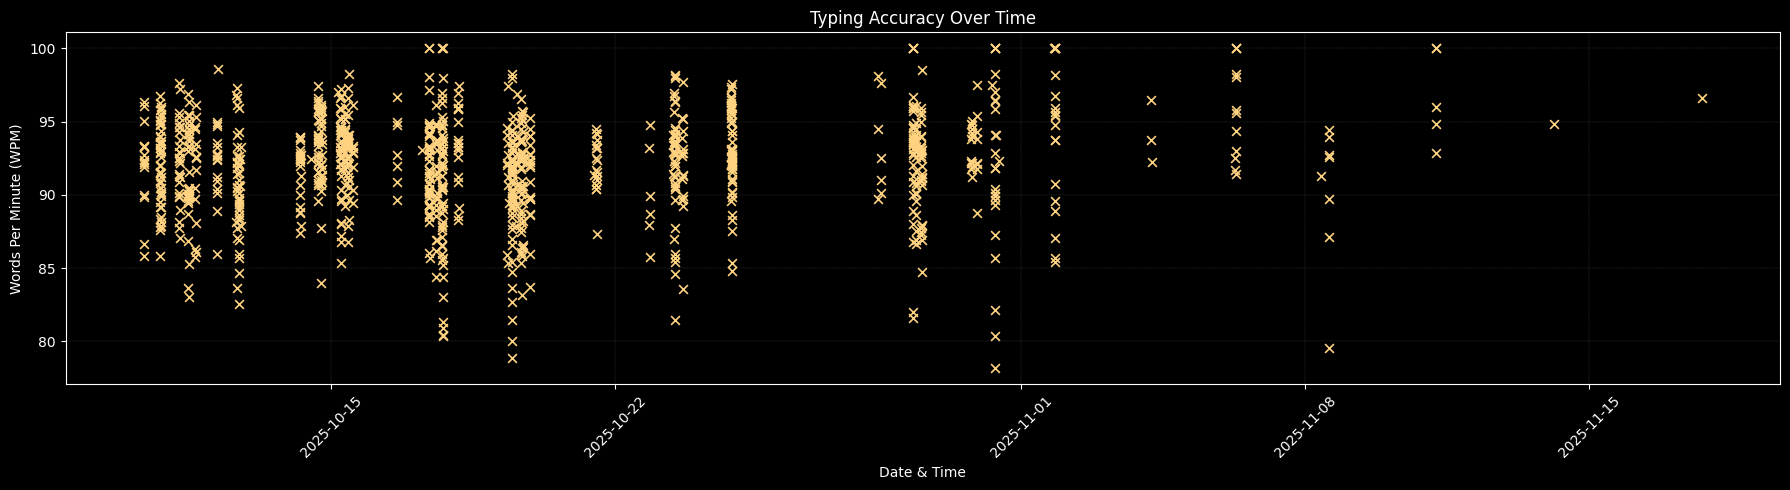

In [30]:
df["time"] = pd.to_datetime(df["timestamp"], unit="ms")
df = df.sort_values("time")

plt.figure(figsize=(18,5))
plt.style.use("dark_background")

plt.scatter(df["time"], df["wpm"], marker="x", s=40, linewidths=1.2)
plt.xlabel("Date & Time")
plt.ylabel("Words Per Minute (WPM)")
plt.title("Typing Speed Over Time")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", linewidth=0.3, alpha=0.25)

plt.tight_layout()
plt.show()

plt.figure(figsize=(18,5))
plt.style.use("dark_background")

plt.scatter(df["time"], df["acc"], marker="x", s=40, linewidths=1.2, color="#ffd27f")
plt.xlabel("Date & Time")
plt.ylabel("Words Per Minute (WPM)")
plt.title("Typing Accuracy Over Time")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", linewidth=0.3, alpha=0.25)

plt.tight_layout()
plt.show()


Explore Dataset Structure

In [23]:
print("Dataset shape:", df.shape)
print("\nData types:")
print(df.dtypes)
print("\nSummary statistics:")
print(df.describe())

Dataset shape: (1000, 24)

Data types:
_id                       object
isPb                      object
wpm                      float64
acc                      float64
rawWpm                   float64
consistency              float64
charStats                 object
mode                      object
mode2                      int64
quoteLength                int64
restartCount               int64
testDuration             float64
afkDuration                int64
incompleteTestSeconds    float64
punctuation                 bool
numbers                     bool
language                  object
funbox                   float64
difficulty                object
lazyMode                    bool
blindMode                   bool
bailedOut                   bool
tags                     float64
timestamp                  int64
dtype: object

Summary statistics:
              wpm          acc       rawWpm  consistency        mode2  \
count  1000.00000  1000.000000  1000.000000  1000.000000  100

Select Meaningful Features

In [24]:
meaningful_features = ['wpm', 'acc', 'rawWpm', 'consistency', 'testDuration', 'afkDuration', 'incompleteTestSeconds', 'restartCount']
# Select only available columns to avoid KeyError if dataset columns differ
available = [c for c in meaningful_features if c in df.columns]
missing = [c for c in meaningful_features if c not in df.columns]
if missing:
    print('Warning: missing columns:', missing)
df_selected = df[available].copy()
print('Selected features:')
print(df_selected.head())

# Impute numeric missing values with median if any NaNs are present
from sklearn.impute import SimpleImputer
if df_selected.isnull().values.any():
    print('\nMissing values present — imputing numeric columns with median')
    imputer = SimpleImputer(strategy='median')
    df_selected[df_selected.columns] = imputer.fit_transform(df_selected)
else:
    print('\nNo missing values detected in selected features')

Selected features:
     wpm     acc  rawWpm  consistency  testDuration  afkDuration  \
0  79.99   96.63   79.99        65.69         30.00            0   
1  70.80   94.87   74.00        65.44         30.00            0   
2  92.61   94.83  124.91        92.98          5.57            0   
3  99.95  100.00   99.95        73.30          5.52            0   
4  79.28   92.86  113.84        82.97          5.90            0   

   incompleteTestSeconds  restartCount  
0                  30.39             4  
1                   0.37             2  
2                   4.87             2  
3                  11.17             7  
4                  34.82            16  

No missing values detected in selected features


Data Visualization

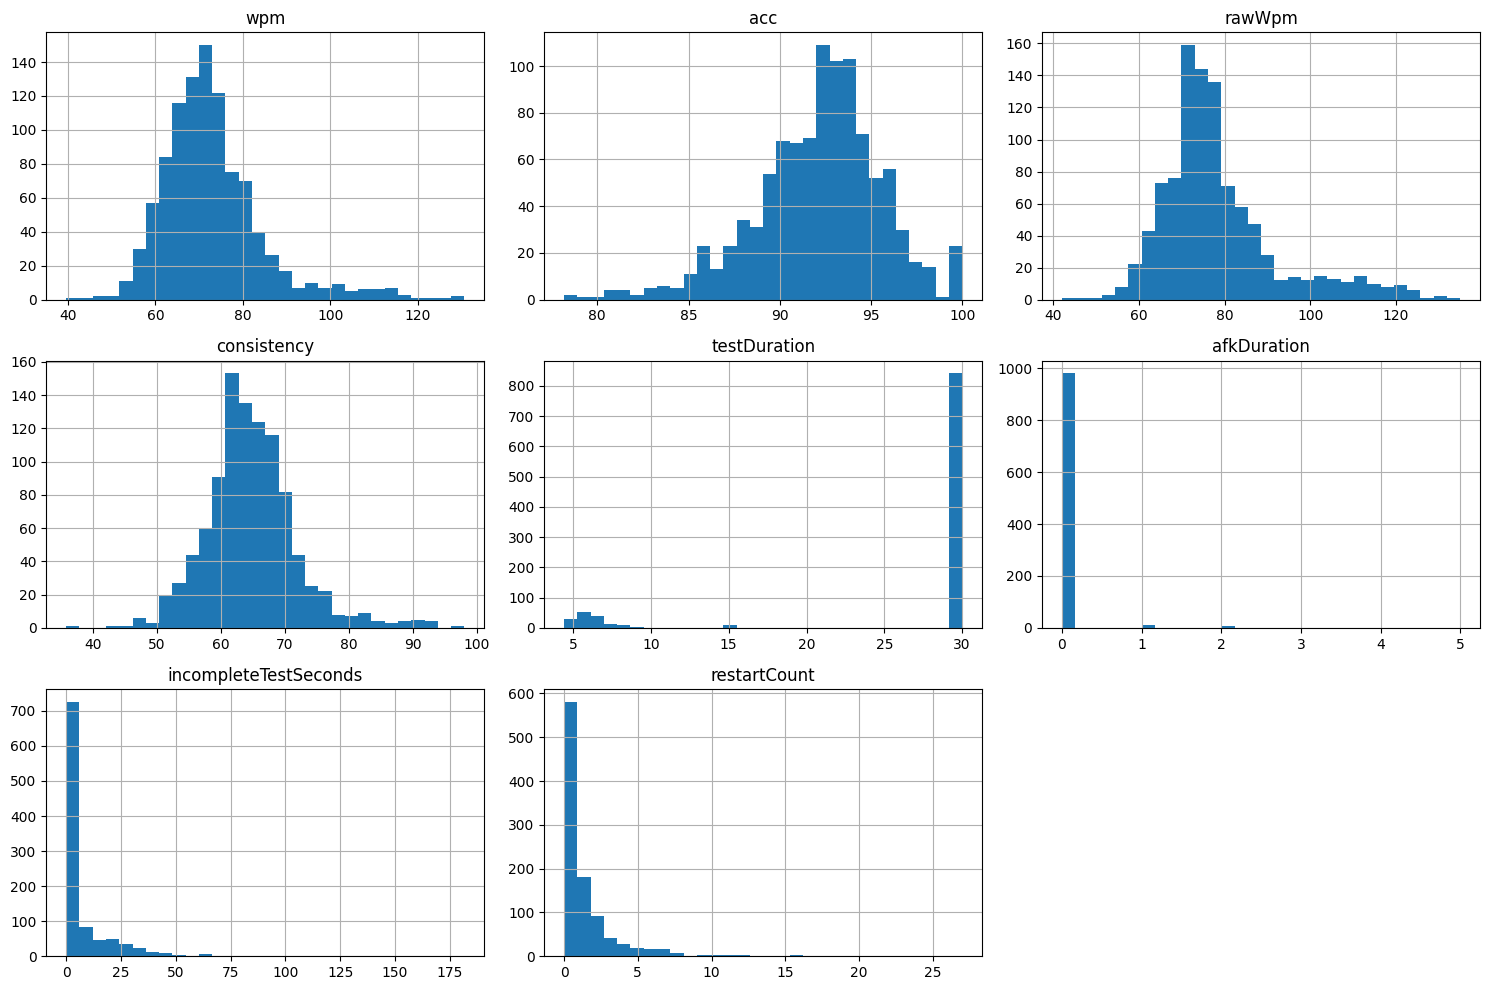

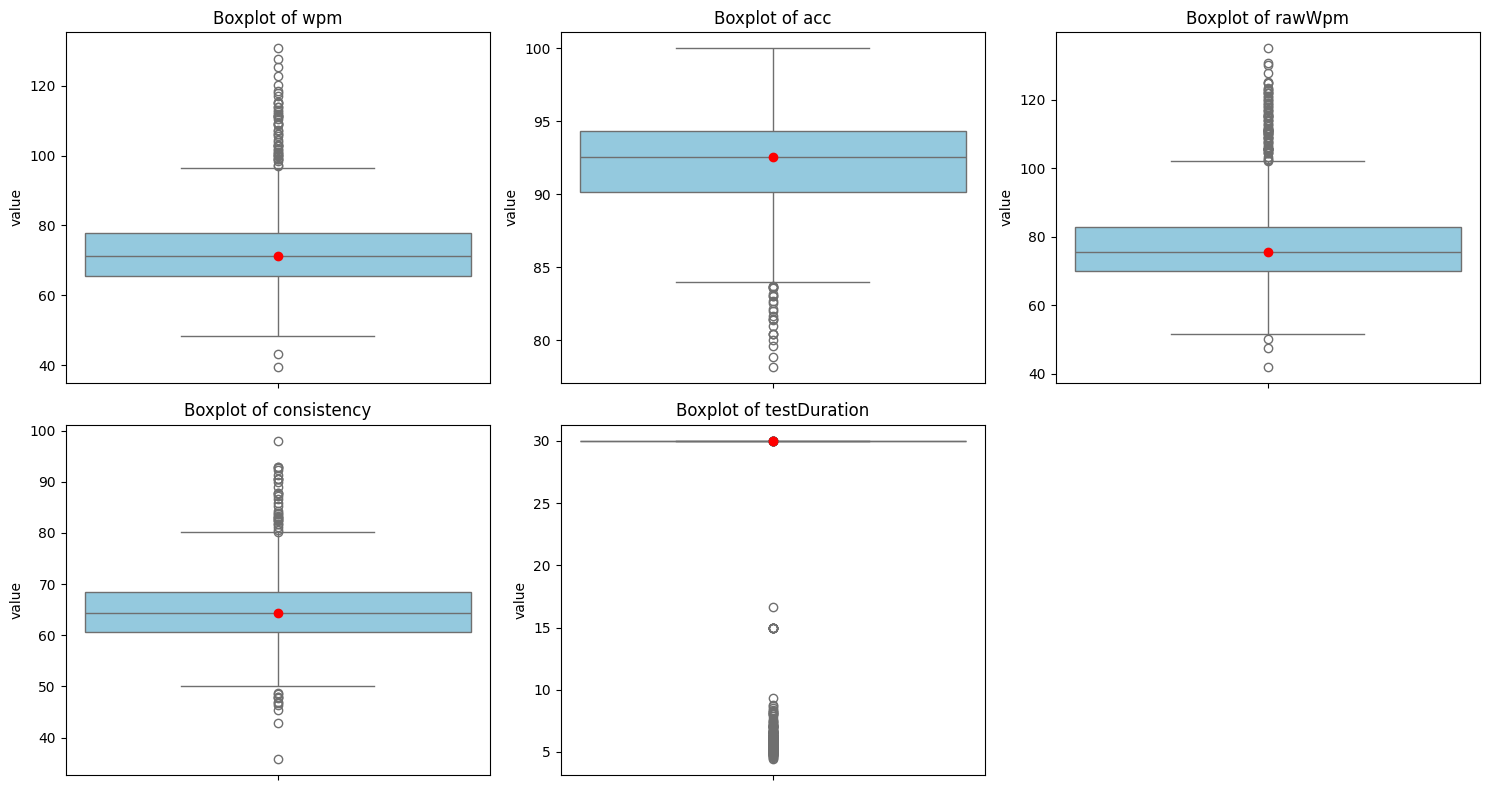

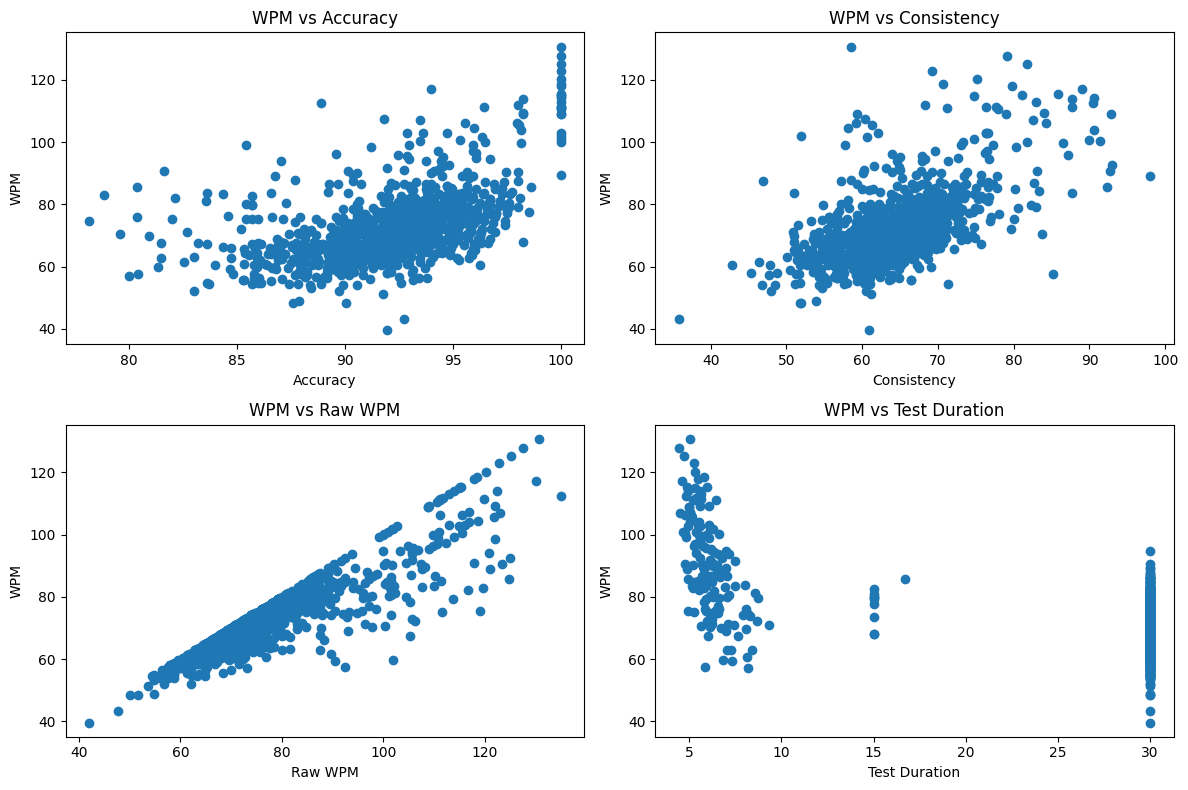

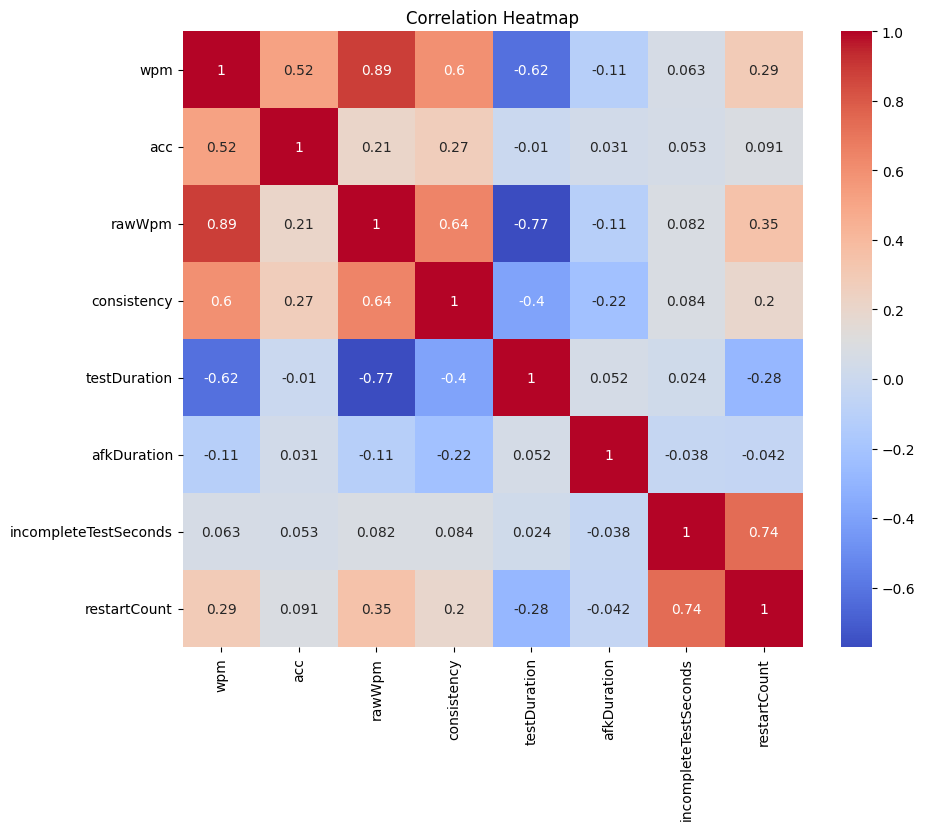

In [25]:
# Histograms
df_selected.hist(bins=30, figsize=(15,10))
plt.tight_layout()
plt.show()

# Improved dynamic boxplots for each feature (exclude certain low-cardinality columns)
import math
exclude_boxplot = ['afkDuration', 'incompleteTestSeconds', 'restartCount']
df_box = df_selected.drop(columns=exclude_boxplot, errors='ignore')
cols = 3
n = len(df_box.columns)
rows = math.ceil(n / cols) if n>0 else 1
plt.figure(figsize=(cols * 5, rows * 4))
for i, col in enumerate(df_box.columns):
    ax = plt.subplot(rows, cols, i+1)
    data = df_box[col].dropna()
    if data.empty:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_title(f'Boxplot of {col} (no data)')
        ax.set_xticks([])
        continue

    # Heuristic: use log scale for strictly positive and very skewed features
    if (data > 0).all() and (data.skew() > 2):
        sns.boxplot(y=np.log1p(data), ax=ax, color='skyblue')
        ax.set_ylabel('log(1 + value)')
        ax.set_title(f'Boxplot of {col} (log scale)')
    else:
        sns.boxplot(y=data, ax=ax, color='skyblue')
        ax.set_ylabel('value')
        ax.set_title(f'Boxplot of {col}')

    # Mark median for clarity
    median = data.median()
    if (data > 0).all() and (data.skew() > 2):
        ax.scatter(0, np.log1p(median), color='red', zorder=10)
    else:
        ax.scatter(0, median, color='red', zorder=10)

plt.tight_layout()
plt.show()

# Scatter plots for key relationships
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.scatter(df_selected['acc'], df_selected['wpm'])
plt.xlabel('Accuracy')
plt.ylabel('WPM')
plt.title('WPM vs Accuracy')

plt.subplot(2,2,2)
plt.scatter(df_selected['consistency'], df_selected['wpm'])
plt.xlabel('Consistency')
plt.ylabel('WPM')
plt.title('WPM vs Consistency')

plt.subplot(2,2,3)
plt.scatter(df_selected['rawWpm'], df_selected['wpm'])
plt.xlabel('Raw WPM')
plt.ylabel('WPM')
plt.title('WPM vs Raw WPM')

plt.subplot(2,2,4)
plt.scatter(df_selected['testDuration'], df_selected['wpm'])
plt.xlabel('Test Duration')
plt.ylabel('WPM')
plt.title('WPM vs Test Duration')
plt.tight_layout()
plt.show()

# Correlation heatmap
corr = df_selected.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Perform Statistical Analysis

In [11]:
print("Correlation matrix:")
print(corr)

# Additional stats
print("\nSkewness:")
print(df_selected.skew())

print("\nKurtosis:")
print(df_selected.kurtosis())

Correlation matrix:
                            wpm       acc    rawWpm  consistency  \
wpm                    1.000000  0.630680  0.836934     0.503877   
acc                    0.630680  1.000000  0.254484     0.228925   
rawWpm                 0.836934  0.254484  1.000000     0.602776   
consistency            0.503877  0.228925  0.602776     1.000000   
testDuration          -0.394531 -0.015668 -0.538149    -0.215932   
afkDuration           -0.242416 -0.007829 -0.285976    -0.434584   
incompleteTestSeconds -0.134155 -0.052890 -0.131630    -0.073460   
restartCount          -0.079907 -0.076764 -0.021141     0.033082   

                       testDuration  afkDuration  incompleteTestSeconds  \
wpm                       -0.394531    -0.242416              -0.134155   
acc                       -0.015668    -0.007829              -0.052890   
rawWpm                    -0.538149    -0.285976              -0.131630   
consistency               -0.215932    -0.434584              -0.07

Build and Evaluate Model

In [12]:
# Regression to predict wpm
X = df_selected.drop('wpm', axis=1)
y = df_selected['wpm']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Linear Regression Results:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

# Clustering (use predictors only, not the target 'wpm')
scaler = StandardScaler()
X_for_clustering = X.copy()
X_scaled = scaler.fit_transform(X_for_clustering)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

print("\nK-Means Clustering Results:")
print("Silhouette Score:", silhouette_score(X_scaled, clusters))

Linear Regression Results:
MSE: 14.2398655028313
R2: 0.9069253806518516

K-Means Clustering Results:
Silhouette Score: 0.3040245519270268

K-Means Clustering Results:
Silhouette Score: 0.3040245519270268


Model Visualizations

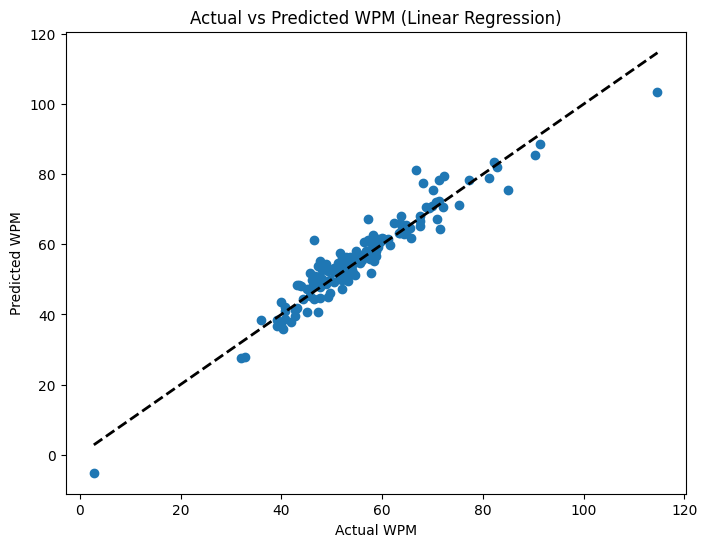

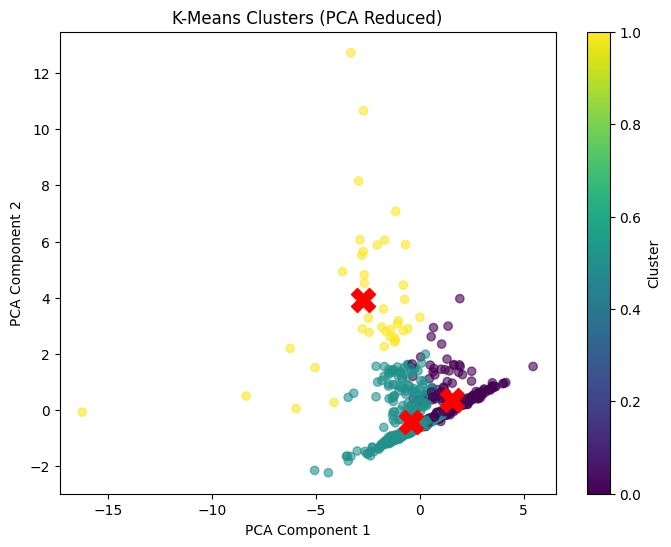

In [13]:
# Regression: Predicted vs Actual
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual WPM')
plt.ylabel('Predicted WPM')
plt.title('Actual vs Predicted WPM (Linear Regression)')
plt.show()

# Clustering: Visualize clusters (using PCA for 2D)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
# Project cluster centers (which are in scaled feature space) into PCA space before plotting
centers_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='viridis', alpha=0.6)
plt.scatter(centers_pca[:,0], centers_pca[:,1], s=300, c='red', marker='X')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clusters (PCA Reduced)')
plt.colorbar(label='Cluster')
plt.show()